In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as feature
import glob

In [2]:
#--- Gulf Stream
latitude_north = 51
latitude_south = 30
longitude_west = -80
longitude_east = -55

#--- Oaxaca (zoomed in)
# latitude_north = 21
# latitude_south = 8
# longitude_west = -105
# longitude_east = -85

## Plotting a single day SST

In [3]:
date_str = "20250312"

sst_file = "sst_data/sst_"+date_str

sst_ds = xr.open_dataset(sst_file, engine='netcdf4')
sst_ds =  sst_ds.squeeze()

#--- Convert from C to K
sst_ds.sst.values = sst_ds.sst.values+273.15

#--- Fill the nan values with zero
#sst_ds = sst_ds.sst.fillna(0)

In [4]:
sst_ds = sst_ds.sel(lat=slice(latitude_north,latitude_south,-1), lon=slice(longitude_west+360,longitude_east+360))

/var/folders/pd/x01_y6d52zj47w6_m5_h_8f80000gr/T/ipykernel_7683/1852624604.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


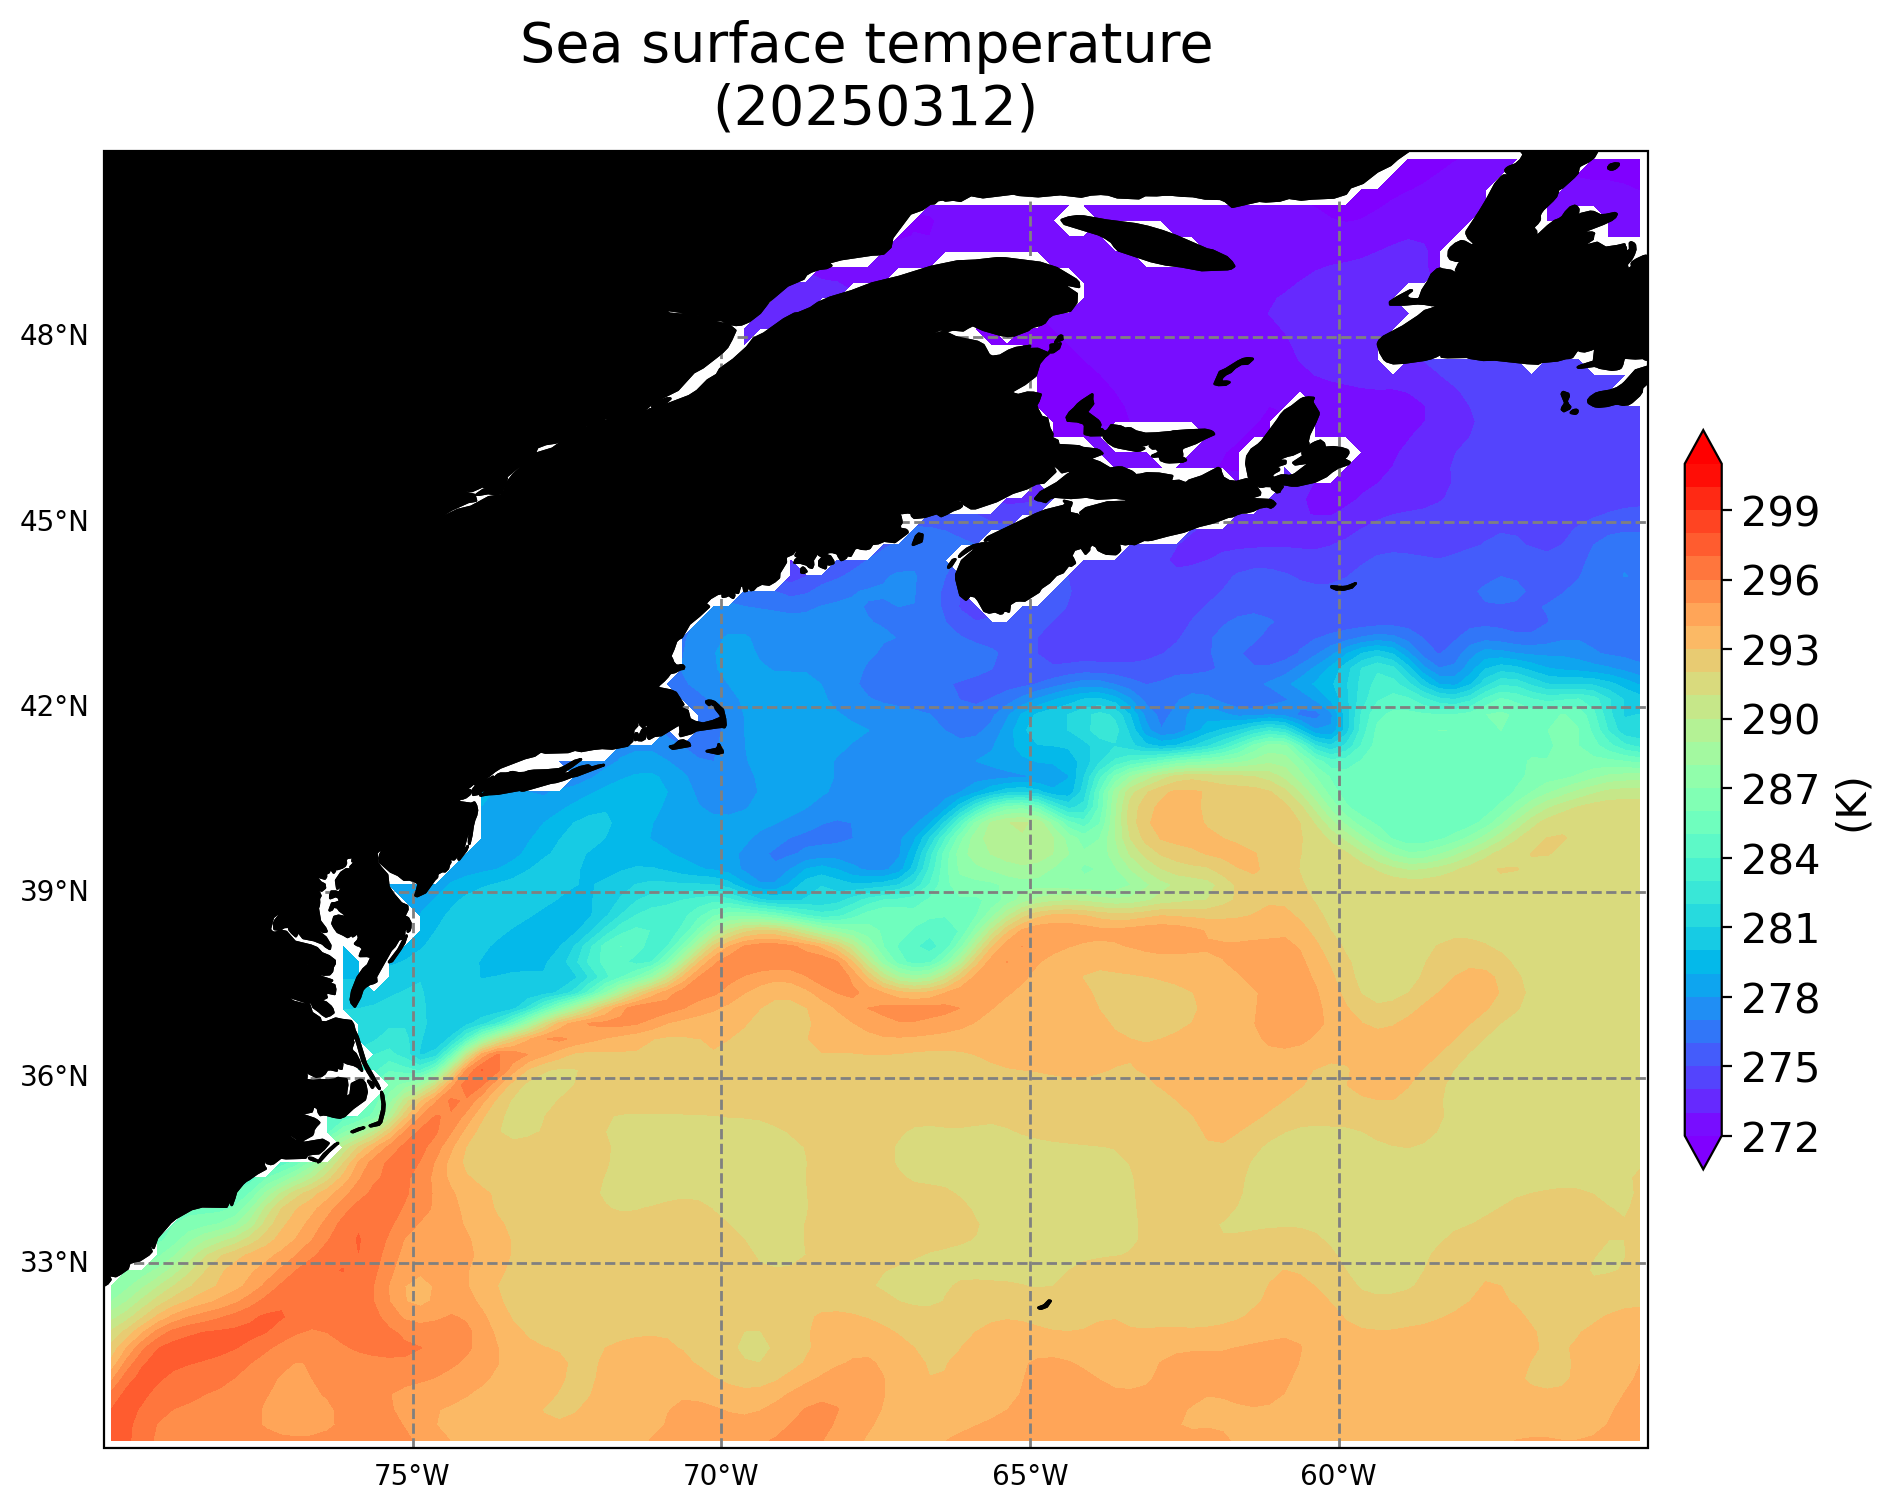

In [8]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

levels = np.linspace(272, 301, 30)
#levels = np.linspace(291, 303, 30)
cmap = plt.get_cmap('rainbow')

c=ax.contourf(sst_ds.lon, sst_ds.lat, sst_ds['sst'].values, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax, extend='both')
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)
#custom_ticks = [295, 296, 297, 298, 299, 300, 301, 302]
#clb.set_ticks(custom_ticks)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Sea surface temperature \n("+date_str[:10]+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)

#--- Land mask
#ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#DABC94')
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#000')

#--- Lat and Lon lines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--', zorder=5)
gl.top_labels = False
gl.right_labels = False

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.1f}°E' if x >= 0 else f'{-x:.1f}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{y:.1f}°N' if y >= 0 else f'{-y:.1f}°S'))


fig.set_dpi(200)
fig.show()

## Making the average SST

In [6]:
date_range = ["20240703", "20240704", "20240705", "20240706", "20240707", "20240708", "20240709", "20240710", "20240711", "20240712"]

In [7]:
data_arrays = []
directory = "sst_data/"
file_patterns = [f"{directory}sst_{day}" for day in date_range]

files = []
for pattern in file_patterns:
    files.extend(glob.glob(pattern))

for file_path in files:
    try:
        data_array = xr.open_dataset(file_path)
        data_arrays.append(data_array)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error opening file {file_path}: {e}")

# Stack the DataArrays along a new dimension, then take the mean across that dimension
if data_arrays:
    mean_SST = xr.concat(data_arrays, dim="time").mean(dim="time")
else:
    mean_SST = None
    print("No valid data arrays found.")

No valid data arrays found.


In [8]:
#--- Remove the vertical dimension
mean_SST = mean_SST.sel(zlev=0.0)

#--- Convert from C to K
mean_SST.sst.values = mean_SST.sst.values+273.15

AttributeError: 'NoneType' object has no attribute 'sel'

In [9]:
mean_SST

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
    zlev     float32 0.0
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (lat, lon) float32 nan nan nan nan nan ... 271.8 271.4 271.4 271.4
    anom     (lat, lon) float32 nan nan nan nan nan ... 0.365 0.4 0.0 0.0 0.0
    err      (lat, lon) float32 nan nan nan nan nan nan ... 0.3 0.3 0.3 0.3 0.3
    ice      (lat, lon) float32 nan nan nan nan nan ... 0.952 0.952 0.952 0.952

/var/folders/pd/x01_y6d52zj47w6_m5_h_8f80000gr/T/ipykernel_62166/2599480404.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


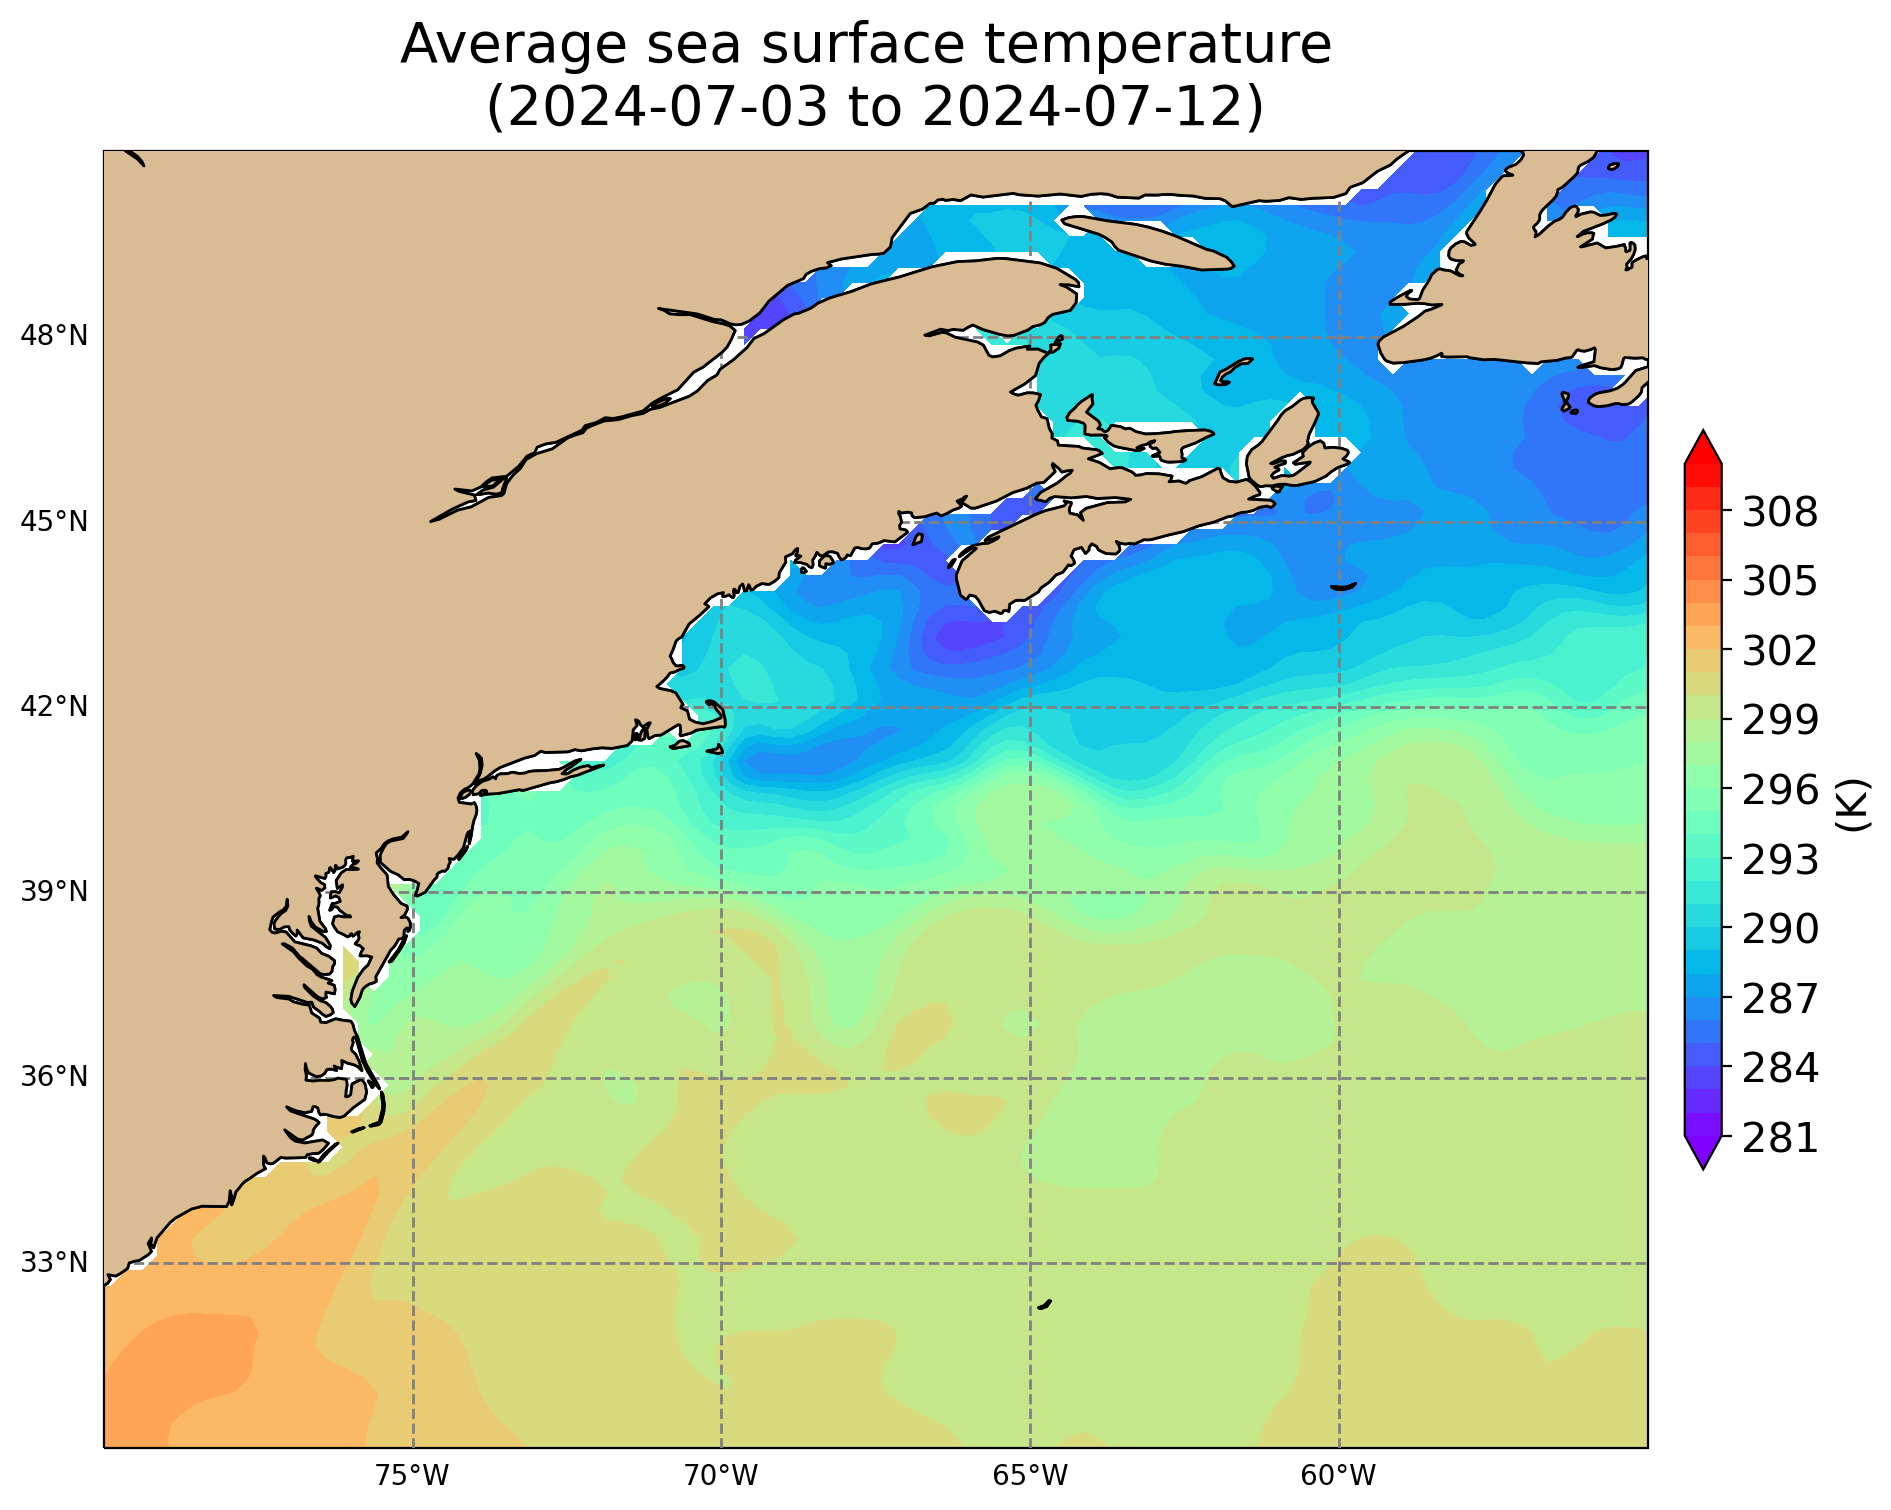

In [10]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

levels = np.linspace(281, 310, 30)
#levels = np.linspace(294, 303, 30)
cmap = plt.get_cmap('rainbow')

c=ax.contourf(mean_SST.lon, mean_SST.lat, mean_SST["sst"].values, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax, extend='both')
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)
#custom_ticks = [295, 296, 297, 298, 299, 300, 301, 302]
#clb.set_ticks(custom_ticks)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Average sea surface temperature \n(2024-07-03 to 2024-07-12)", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)

#--- Land in tan
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#DABC94')

#--- Lat and Lon lines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--', zorder=5)
gl.top_labels = False
gl.right_labels = False

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.1f}°E' if x >= 0 else f'{-x:.1f}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{y:.1f}°N' if y >= 0 else f'{-y:.1f}°S'))


fig.set_dpi(200)
fig.show()